<a href="https://colab.research.google.com/github/Risad-Raihan/Demand_analysis/blob/main/1ltre_sarima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('/content/drive/My Drive/ops_segmentation-main/1litere_2.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4410 non-null   object 
 1   outlet_id  4410 non-null   int64  
 2   item       4410 non-null   object 
 3   quantity   4410 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 137.9+ KB


In [10]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from datetime import datetime

 #Step 1: Prepare DataFrame for SARIMA
# Convert Date to datetime format and set it as index
#df['Date'] = pd.to_datetime(df['Date'])
#df.set_index('Date', inplace=True)

# Step 2: Drop unnecessary columns
#df.drop(columns=['category'], inplace=True)

# Step 3: Aggregate Data by Month
monthly_data = df.resample('MS')['quantity'].sum()

# Check if monthly_data is empty
df_empty_check = monthly_data.empty
if df_empty_check:
    raise ValueError("The monthly aggregated data is empty. Please check the input data.")

# Step 4: Check Stationarity using Augmented Dickey-Fuller Test
adf_result = adfuller(monthly_data)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value}")
if adf_result[1] > 0.05:
    print("The data is non-stationary. Differencing may be required.")
else:
    print("The data is stationary.")

ADF Statistic: 0.5632657794177115
p-value: 0.9866743124913593
Critical Value (1%): -4.01203360058309
Critical Value (5%): -3.1041838775510207
Critical Value (10%): -2.6909873469387753
The data is non-stationary. Differencing may be required.


In [11]:
monthly_data

,quantity
Date,
2023-05-01,528.00
2023-06-01,593.00
2023-07-01,688.44
2023-08-01,770.56
2023-09-01,758.00
2023-10-01,825.00
2023-11-01,639.10
2023-12-01,713.50
2024-01-01,851.00


In [12]:
# Step 4: Further Differencing or Seasonal Differencing
diff_order = 1
monthly_data_diff = monthly_data.copy()

while diff_order <= 3:
    monthly_data_diff = monthly_data_diff.diff().dropna()
    adf_result_diff = adfuller(monthly_data_diff)
    print(f"\nAfter {diff_order} Order Differencing:")
    print(f"ADF Statistic: {adf_result_diff[0]}")
    print(f"p-value: {adf_result_diff[1]}")
    for key, value in adf_result_diff[4].items():
        print(f"Critical Value ({key}): {value}")
    if adf_result_diff[1] <= 0.05:
        print("The data is now stationary.")
        break
    diff_order += 1

if diff_order > 3:
    raise ValueError("The data could not be made stationary even after third-order differencing.")



After 1 Order Differencing:
ADF Statistic: 1.7759362867305353
p-value: 0.9983000772069632
Critical Value (1%): -4.331573
Critical Value (5%): -3.23295
Critical Value (10%): -2.7487

After 2 Order Differencing:
ADF Statistic: -0.07305708987459855
p-value: 0.9520569008395204
Critical Value (1%): -4.473135048010974
Critical Value (5%): -3.28988060356653
Critical Value (10%): -2.7723823456790124

After 3 Order Differencing:
ADF Statistic: -10.006483956752385
p-value: 1.8257518818978074e-17
Critical Value (1%): -4.473135048010974
Critical Value (5%): -3.28988060356653
Critical Value (10%): -2.7723823456790124
The data is now stationary.


In [13]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime


In [14]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime

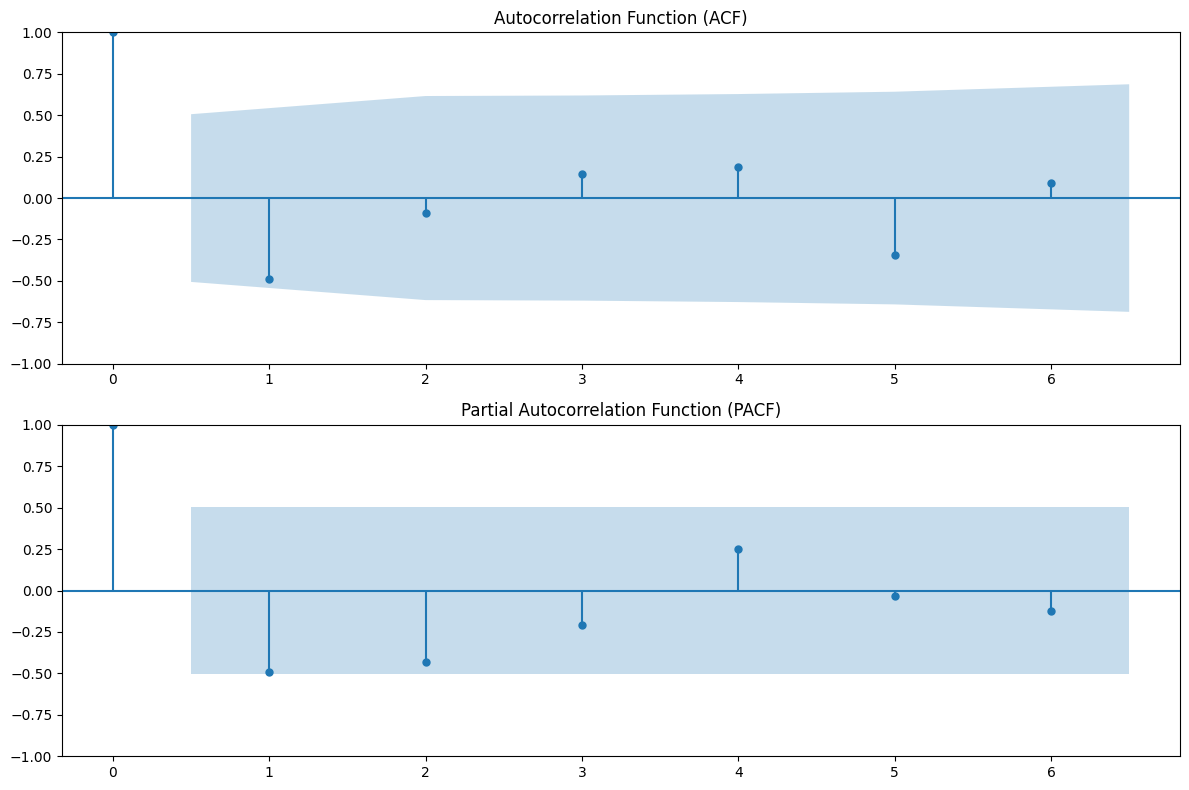

In [15]:
# Step 5: Plot ACF and PACF to Determine Parameters
max_lags = len(monthly_data_diff) // 2 - 1
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
sm.graphics.tsa.plot_acf(monthly_data_diff.squeeze(), lags=max_lags, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')
sm.graphics.tsa.plot_pacf(monthly_data_diff.squeeze(), lags=max_lags, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()


In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Step 6: Fit SARIMA Model
sarima_model = SARIMAX(monthly_data,
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 0, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_fit = sarima_model.fit(disp=False)

# Step 7: Model Summary
print(sarima_fit.summary())

# Step 8: Plot Diagnostics
sarima_fit.plot_diagnostics(figsize=(15, 10))
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                      SARIMAX Results                                      
Dep. Variable:                            quantity   No. Observations:                   18
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                   0.000
Date:                             Sun, 27 Oct 2024   AIC                              8.000
Time:                                     17:09:51   BIC                                nan
Sample:                                 05-01-2023   HQIC                               nan
                                      - 10-01-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2720         -0        inf      0.000      -1.272      -1.272
ma.L1          0.7767      

/usr/local/lib/python3.10/dist-packages/statsmodels/tools/eval_measures.py:414: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + np.log(nobs) * df_modelwc
/usr/local/lib/python3.10/dist-packages/statsmodels/tools/eval_measures.py:439: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + 2 * np.log(np.log(nobs)) * df_modelwc
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:472: RuntimeWarning: Mean of empty slice.
  xo = x - x.mean()
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 1500x1000 with 0 Axes>

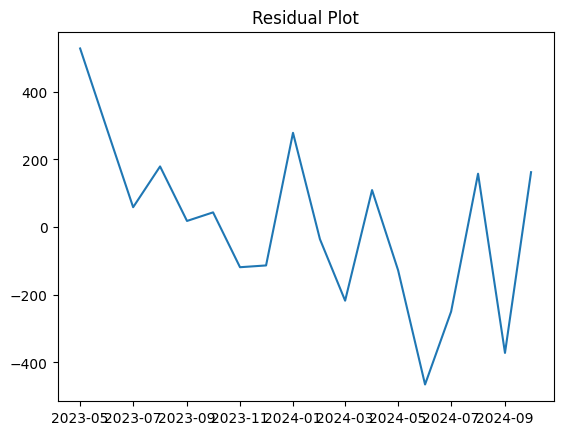

In [17]:
residuals = sarima_fit.resid
plt.plot(residuals)
plt.title('Residual Plot')
plt.show()


In [1]:
# ekhan theke weekly data shuru


In [7]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime

 #Step 1: Prepare DataFrame for SARIMA
# Convert Date to datetime format and set it as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Step 2: Aggregate Data by Week
weekly_data = df.resample('W')['quantity'].sum()

# Check if weekly_data is empty
df_empty_check = weekly_data.empty
if df_empty_check:
    raise ValueError("The weekly aggregated data is empty. Please check the input data.")

In [5]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime

#Step 1: Prepare DataFrame for SARIMA
# Convert Date to datetime format and set it as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


# Step 2: Aggregate Data by Week
weekly_data = df.resample('W-FRI')['quantity'].sum()

# Check if weekly_data is empty
df_empty_check = weekly_data.empty
if df_empty_check:
    raise ValueError("The weekly aggregated data is empty. Please check the input data.")

# Step 3: Check Stationarity using ADF Test
adf_result = adfuller(weekly_data)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value}")
if adf_result[1] > 0.05:
    print("The data is non-stationary. Differencing may be required.")

    # Step 4: Differencing to Make Data Stationary
    weekly_data_diff = weekly_data.diff().dropna()

    # Recheck Stationarity
    adf_result_diff = adfuller(weekly_data_diff)
    print("\nAfter Differencing:")
    print(f"ADF Statistic: {adf_result_diff[0]}")
    print(f"p-value: {adf_result_diff[1]}")
    for key, value in adf_result_diff[4].items():
        print(f"Critical Value ({key}): {value}")
    if adf_result_diff[1] > 0.05:
        # Step 5: Seasonal Differencing if Needed
        weekly_data_seasonal_diff = weekly_data_diff.diff(52).dropna()  # Assuming weekly seasonality with 52 weeks
        adf_result_seasonal_diff = adfuller(weekly_data_seasonal_diff)
        print("\nAfter Seasonal Differencing:")
        print(f"ADF Statistic: {adf_result_seasonal_diff[0]}")
        print(f"p-value: {adf_result_seasonal_diff[1]}")
        for key, value in adf_result_seasonal_diff[4].items():
            print(f"Critical Value ({key}): {value}")
        if adf_result_seasonal_diff[1] > 0.05:
            raise ValueError("The data is still non-stationary after seasonal differencing.")
        else:
            print("The data is now stationary after seasonal differencing.")
    else:
        print("The data is now stationary after differencing.")
else:
    print("The data is stationary.")



ADF Statistic: -1.3775606906163242
p-value: 0.5929852836553131
Critical Value (1%): -3.530398990560757
Critical Value (5%): -2.9050874099328317
Critical Value (10%): -2.5900010121107266
The data is non-stationary. Differencing may be required.

After Differencing:
ADF Statistic: -6.651674261326187
p-value: 5.102387285955666e-09
Critical Value (1%): -3.530398990560757
Critical Value (5%): -2.9050874099328317
Critical Value (10%): -2.5900010121107266
The data is now stationary after differencing.


ADF Statistic: -1.3775606906163242
p-value: 0.5929852836553131
Critical Value (1%): -3.530398990560757
Critical Value (5%): -2.9050874099328317
Critical Value (10%): -2.5900010121107266
The data is non-stationary. Differencing may be required.

After Differencing:
ADF Statistic: -6.651674261326187
p-value: 5.102387285955666e-09
Critical Value (1%): -3.530398990560757
Critical Value (5%): -2.9050874099328317
Critical Value (10%): -2.5900010121107266
The data is now stationary after differencing.


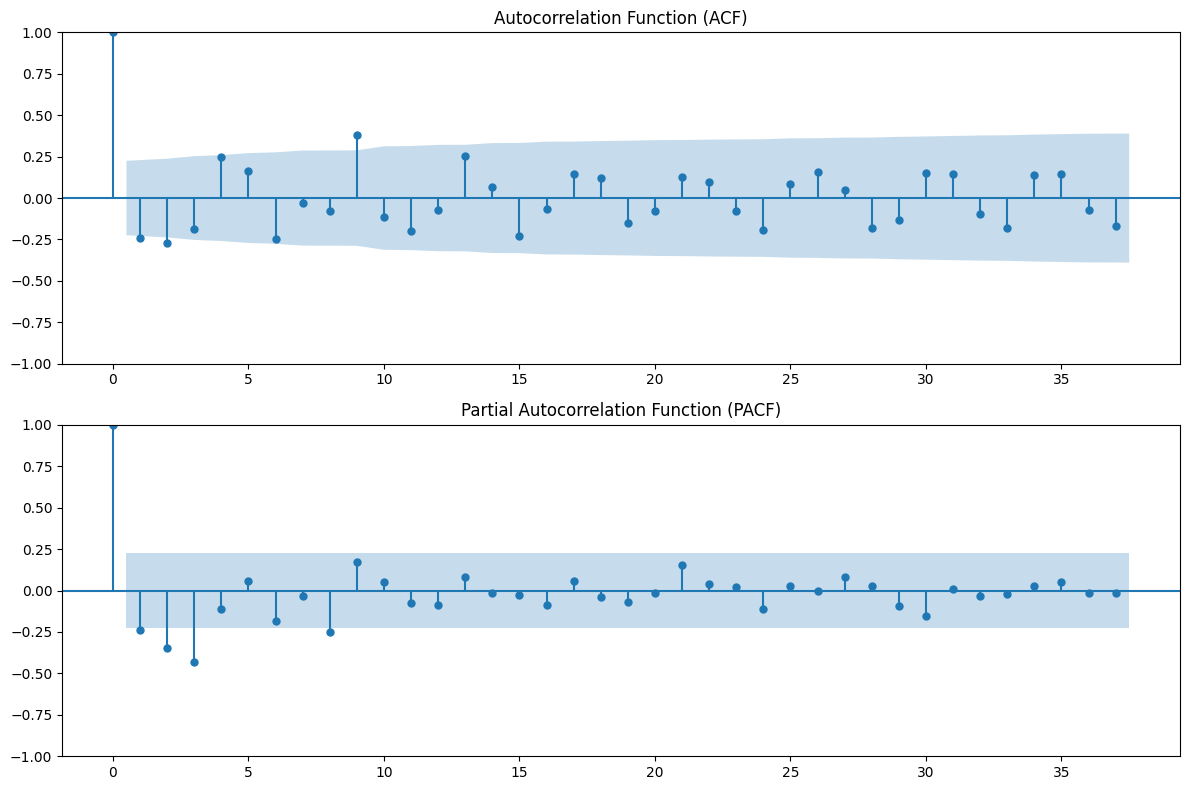

In [6]:
# Step 1: Prepare DataFrame for Stationarity Check
# Convert Date to datetime format and set it as index (already done)

# Step 2: Aggregate Data by Week
#weekly_data = df.resample('W')['quantity'].sum()

# Check if weekly_data is empty
df_empty_check = weekly_data.empty
if df_empty_check:
    raise ValueError("The weekly aggregated data is empty. Please check the input data.")

# Step 3: Check Stationarity using ADF Test
adf_result = adfuller(weekly_data)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value}")

# Initialize weekly_data_diff for plotting
weekly_data_diff = weekly_data.diff().dropna()

if adf_result[1] > 0.05:
    print("The data is non-stationary. Differencing may be required.")

    # Step 4: Differencing to Make Data Stationary
    weekly_data_diff = weekly_data.diff().dropna()

    # Recheck Stationarity
    adf_result_diff = adfuller(weekly_data_diff)
    print("\nAfter Differencing:")
    print(f"ADF Statistic: {adf_result_diff[0]}")
    print(f"p-value: {adf_result_diff[1]}")
    for key, value in adf_result_diff[4].items():
        print(f"Critical Value ({key}): {value}")
    if adf_result_diff[1] > 0.05:
        # Step 5: Seasonal Differencing if Needed
        weekly_data_seasonal_diff = weekly_data_diff.diff(52).dropna()  # Assuming weekly seasonality with 52 weeks
        adf_result_seasonal_diff = adfuller(weekly_data_seasonal_diff)
        print("\nAfter Seasonal Differencing:")
        print(f"ADF Statistic: {adf_result_seasonal_diff[0]}")
        print(f"p-value: {adf_result_seasonal_diff[1]}")
        for key, value in adf_result_seasonal_diff[4].items():
            print(f"Critical Value ({key}): {value}")
        if adf_result_seasonal_diff[1] > 0.05:
            raise ValueError("The data is still non-stationary after seasonal differencing.")
        else:
            print("The data is now stationary after seasonal differencing.")
            weekly_data_diff = weekly_data_seasonal_diff
    else:
        print("The data is now stationary after differencing.")
else:
    print("The data is stationary.")

# Step 6: Plot ACF and PACF to Determine Parameters
max_lags = len(weekly_data_diff) // 2 - 1
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
sm.graphics.tsa.plot_acf(weekly_data_diff.squeeze(), lags=max_lags, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')
sm.graphics.tsa.plot_pacf(weekly_data_diff.squeeze(), lags=max_lags, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()


In [8]:
# Step 7: Fit SARIMA Model
d = 1
D = 1
p, q = 2, 2  # Based on PACF and ACF observations
P, Q, s = 1, 1, 52  # Assuming yearly seasonality for weekly data

sarima_model = sm.tsa.statespace.SARIMAX(weekly_data,
                                         order=(p, d, q),
                                         seasonal_order=(P, D, Q, s),
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)
sarima_fit = sarima_model.fit(disp=False)
print(sarima_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                      SARIMAX Results                                       
Dep. Variable:                             quantity   No. Observations:                   77
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 52)   Log Likelihood                   0.000
Date:                              Mon, 28 Oct 2024   AIC                             14.000
Time:                                      04:12:23   BIC                                nan
Sample:                                  05-19-2023   HQIC                               nan
                                       - 11-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9179         -0        inf      0.000      -0.918      -0.918
ar.L2         -0.14

/usr/local/lib/python3.10/dist-packages/statsmodels/tools/eval_measures.py:414: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + np.log(nobs) * df_modelwc
/usr/local/lib/python3.10/dist-packages/statsmodels/tools/eval_measures.py:439: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + 2 * np.log(np.log(nobs)) * df_modelwc
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:472: RuntimeWarning: Mean of empty slice.
  xo = x - x.mean()
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [9]:
# Step 9: Forecast for August, September, October, and November
forecast_steps = 17  # Forecast for 17 weeks to cover August to November
forecast = sarima_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

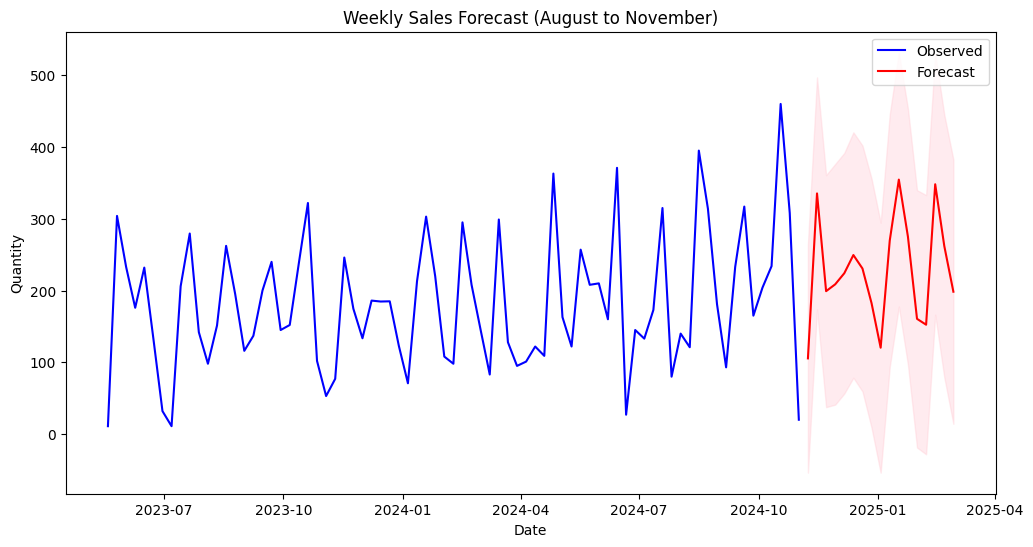

In [10]:
# Step 10: Plot Forecast
plt.figure(figsize=(12, 6))
plt.plot(weekly_data.index, weekly_data, label='Observed', color='blue')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_mean.index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1],
                 color='pink', alpha=0.3)
plt.legend()
plt.title('Weekly Sales Forecast (August to November)')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.show()


In [13]:
# Step 9: Forecast for November
forecast_steps = 4  # Forecast for 4 weeks to cover November
forecast = sarima_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

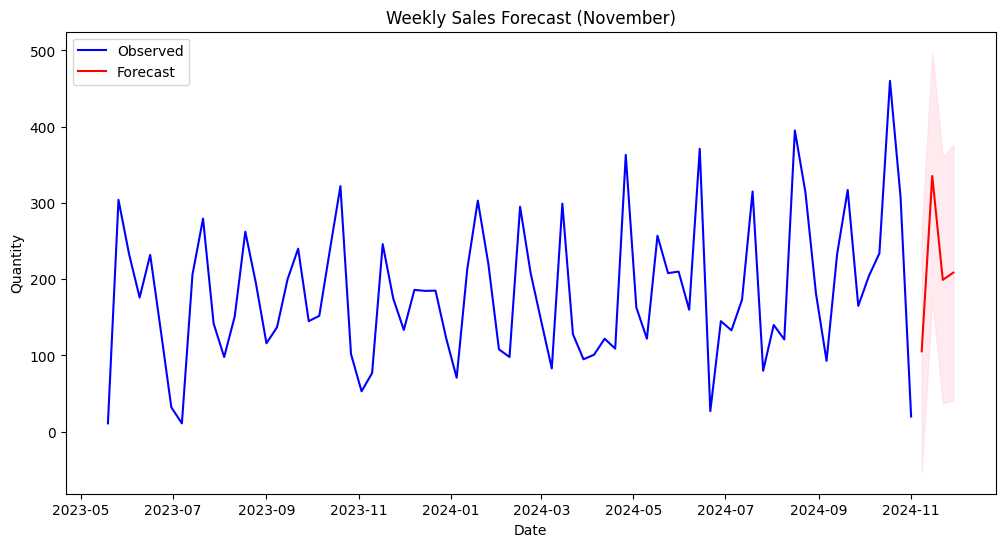

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(weekly_data.index, weekly_data, label='Observed', color='blue')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_mean.index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1],
                 color='pink', alpha=0.3)
plt.legend()
plt.title('Weekly Sales Forecast (November)')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.show()

In [18]:
# Step 11: Calculate Error Metrics for Model Performance
# Adjust actual data to match the forecast index
actual_november_data = weekly_data['2024-11-01':'2024-11-29']
actual_november_data_aligned = actual_november_data.reindex(forecast_mean.index)

# Ensure lengths are equal for calculations
if len(actual_november_data_aligned) == len(forecast_mean):
    # Mean Error (ME)
    me = np.mean(forecast_mean - actual_november_data_aligned)

    # Root Mean Square Error (RMSE)
    rmse = np.sqrt(np.mean((forecast_mean - actual_november_data_aligned) ** 2))

    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(forecast_mean - actual_november_data_aligned))

    # Mean Percentage Error (MPE)
    mpe = np.mean((forecast_mean - actual_november_data_aligned) / actual_november_data_aligned) * 100

    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((forecast_mean - actual_november_data_aligned) / actual_november_data_aligned)) * 100

    # Print the calculated metrics
    print("\nError Metrics for November:")
    print(f"Mean Error (ME): {me:.2f}")
    print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Percentage Error (MPE): {mpe:.2f}%")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
else:
    print("The actual data and forecasted data lengths do not match for error metric calculations.")



Error Metrics for November:
Mean Error (ME): nan
Root Mean Square Error (RMSE): nan
Mean Absolute Error (MAE): nan
Mean Percentage Error (MPE): nan%
Mean Absolute Percentage Error (MAPE): nan%


In [17]:
actual_november_data = actual_november_data.reindex(forecast_mean.index)


In [19]:
actual_november_data = actual_november_data.dropna()
forecast_mean = forecast_mean.loc[actual_november_data.index]


KeyError: "None of [DatetimeIndex(['2024-11-01'], dtype='datetime64[ns]', name='Date', freq='W-FRI')] are in the [index]"

ADF Statistic: -1.3775606906163242
p-value: 0.5929852836553131
Critical Value (1%): -3.530398990560757
Critical Value (5%): -2.9050874099328317
Critical Value (10%): -2.5900010121107266
The data is non-stationary. Differencing may be required.

After Differencing:
ADF Statistic: -6.651674261326187
p-value: 5.102387285955666e-09
Critical Value (1%): -3.530398990560757
Critical Value (5%): -2.9050874099328317
Critical Value (10%): -2.5900010121107266
The data is now stationary after differencing.


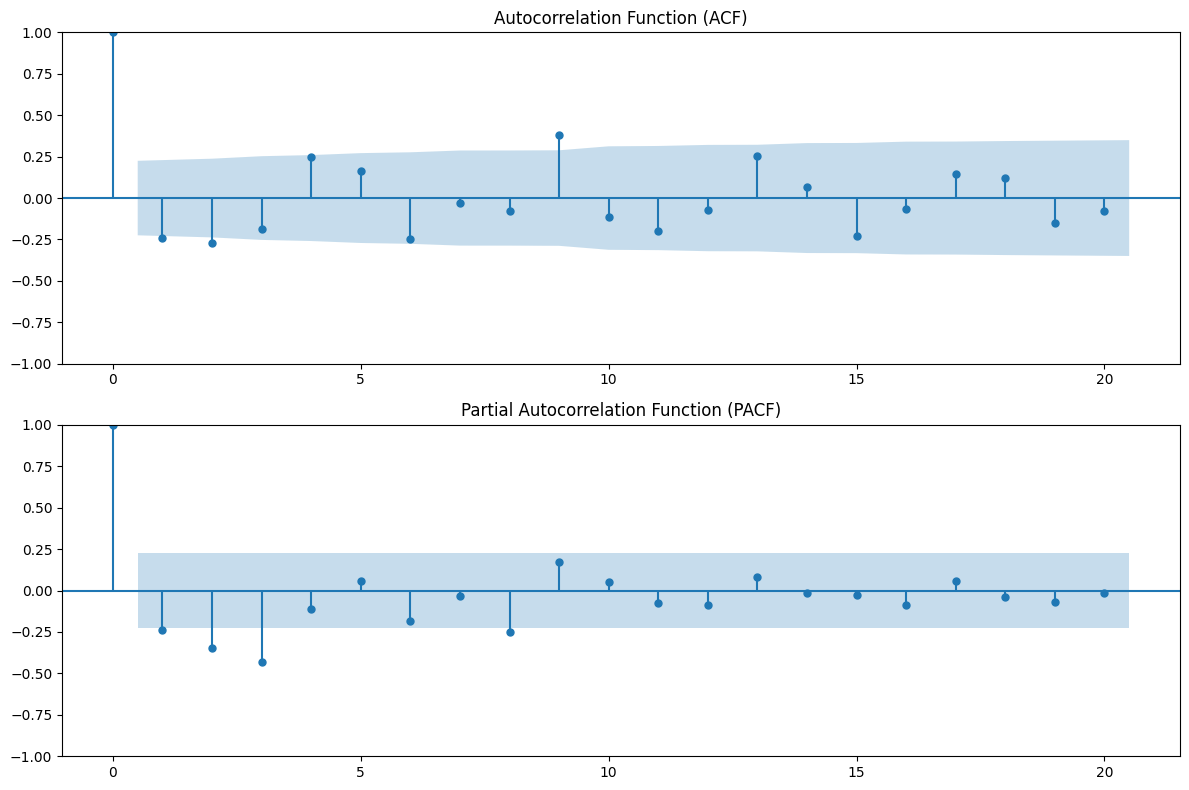

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tools/eval_measures.py:414: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + np.log(nobs) * df_modelwc
/usr/local/lib/python3.10/dist-packages/statsmodels/tools/eval_measures.py:439: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + 2 * np.log(np.log(nobs)) * df_modelwc
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse
/usr

                                      SARIMAX Results                                       
Dep. Variable:                             quantity   No. Observations:                   77
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 52)   Log Likelihood                   0.000
Date:                              Mon, 28 Oct 2024   AIC                             14.000
Time:                                      04:45:52   BIC                                nan
Sample:                                  05-19-2023   HQIC                               nan
                                       - 11-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9179         -0        inf      0.000      -0.918      -0.918
ar.L2         -0.14

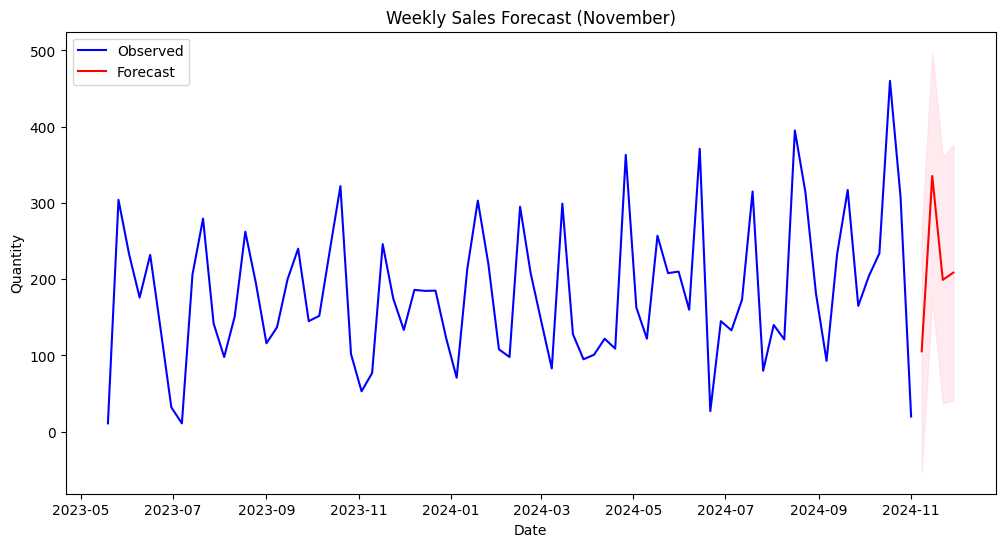

The actual data and forecasted data lengths do not match for error metric calculations.


In [6]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime

# Step 1: Prepare DataFrame for Stationarity Check
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Step 2: Aggregate Data by Week
weekly_data = df.resample('W-FRI')['quantity'].sum()

# Check if weekly_data is empty
df_empty_check = weekly_data.empty
if df_empty_check:
    raise ValueError("The weekly aggregated data is empty. Please check the input data.")

# Step 3: Check Stationarity using ADF Test
adf_result = adfuller(weekly_data)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value}")
if adf_result[1] > 0.05:
    print("The data is non-stationary. Differencing may be required.")

    # Step 4: Differencing to Make Data Stationary
    weekly_data_diff = weekly_data.diff().dropna()

    # Recheck Stationarity
    adf_result_diff = adfuller(weekly_data_diff)
    print("\nAfter Differencing:")
    print(f"ADF Statistic: {adf_result_diff[0]}")
    print(f"p-value: {adf_result_diff[1]}")
    for key, value in adf_result_diff[4].items():
        print(f"Critical Value ({key}): {value}")
    if adf_result_diff[1] > 0.05:
        # Step 5: Seasonal Differencing if Needed
        weekly_data_seasonal_diff = weekly_data_diff.diff(52).dropna()  # Assuming weekly seasonality with 52 weeks
        adf_result_seasonal_diff = adfuller(weekly_data_seasonal_diff)
        print("\nAfter Seasonal Differencing:")
        print(f"ADF Statistic: {adf_result_seasonal_diff[0]}")
        print(f"p-value: {adf_result_seasonal_diff[1]}")
        for key, value in adf_result_seasonal_diff[4].items():
            print(f"Critical Value ({key}): {value}")
        if adf_result_seasonal_diff[1] > 0.05:
            raise ValueError("The data is still non-stationary after seasonal differencing.")
        else:
            print("The data is now stationary after seasonal differencing.")
    else:
        print("The data is now stationary after differencing.")
else:
    print("The data is stationary.")

# Step 6: Plot ACF and PACF to Determine Parameters
max_lags = min(len(weekly_data_diff) // 2 - 1, 20)  # Reduce max_lags to ensure sufficient data points
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
sm.graphics.tsa.plot_acf(weekly_data_diff.squeeze(), lags=max_lags, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')
sm.graphics.tsa.plot_pacf(weekly_data_diff.squeeze(), lags=max_lags, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

# Step 7: Fit SARIMA Model
d = 1
D = 1
p, q = 2, 2  # Based on PACF and ACF observations
P, Q, s = 1, 1, 52  # Assuming yearly seasonality for weekly data

sarima_model = sm.tsa.statespace.SARIMAX(weekly_data,
                                         order=(p, d, q),
                                         seasonal_order=(P, D, Q, s),
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)
sarima_fit = sarima_model.fit(disp=False)
print(sarima_fit.summary())

# Step 9: Forecast for November
forecast_steps = 4  # Forecast for 4 weeks to cover November
forecast = sarima_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Step 10: Plot Forecast
plt.figure(figsize=(12, 6))
plt.plot(weekly_data.index, weekly_data, label='Observed', color='blue')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_mean.index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1],
                 color='pink', alpha=0.3)
plt.legend()
plt.title('Weekly Sales Forecast (November)')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.show()

# Step 11: Calculate Error Metrics for Model Performance
# Assuming we have actual data for comparison (update actual_november_data accordingly)
actual_november_data = weekly_data['2024-11-01':'2024-11-29']

# Ensure lengths are equal for calculations
if len(actual_november_data) == len(forecast_mean):
    # Mean Error (ME)
    me = np.mean(forecast_mean - actual_november_data)

    # Root Mean Square Error (RMSE)
    rmse = np.sqrt(np.mean((forecast_mean - actual_november_data) ** 2))

    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(forecast_mean - actual_november_data))

    # Mean Percentage Error (MPE)
    mpe = np.mean((forecast_mean - actual_november_data) / actual_november_data) * 100

    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((forecast_mean - actual_november_data) / actual_november_data)) * 100

    # Print the calculated metrics
    print("\nError Metrics for November:")
    print(f"Mean Error (ME): {me:.2f}")
    print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Percentage Error (MPE): {mpe:.2f}%")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
else:
    print("The actual data and forecasted data lengths do not match for error metric calculations.")


In [8]:
forecast_mean = forecast_mean.reindex(actual_november_data.index)


In [9]:
actual_november_data = actual_november_data.dropna()
forecast_mean = forecast_mean.dropna()


In [10]:
print("Actual data index:", actual_november_data.index)
print("Forecasted data index:", forecast_mean.index)


Actual data index: DatetimeIndex(['2024-11-01'], dtype='datetime64[ns]', name='Date', freq='W-FRI')
Forecasted data index: DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq='W-FRI')


In [12]:
# Step 11: Calculate Error Metrics for Model Performance
# Since actual November data isn't available, let's validate using past data
test_start = '2024-08-02'
test_end = '2024-10-25'

actual_data = weekly_data[test_start:test_end]
forecast = sarima_fit.get_prediction(start=test_start, end=test_end)
forecast_mean = forecast.predicted_mean

# Ensure lengths are equal for calculations
if len(actual_data) == len(forecast_mean):
    # Mean Error (ME)
    me = np.mean(forecast_mean - actual_data)

    # Root Mean Square Error (RMSE)
    rmse = np.sqrt(np.mean((forecast_mean - actual_data) ** 2))

    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(forecast_mean - actual_data))

    # Mean Percentage Error (MPE)
    mpe = np.mean((forecast_mean - actual_data) / actual_data) * 100

    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((forecast_mean - actual_data) / actual_data)) * 100

    # Print the calculated metrics
    print("\nError Metrics for Validation Period:")
    print(f"Mean Error (ME): {me:.2f}")
    print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Percentage Error (MPE): {mpe:.2f}%")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
else:
    print("The actual data and forecasted data lengths do not match for error metric calculations.")



Error Metrics for Validation Period:
Mean Error (ME): -32.00
Root Mean Square Error (RMSE): 81.20
Mean Absolute Error (MAE): 64.06
Mean Percentage Error (MPE): -2.43%
Mean Absolute Percentage Error (MAPE): 31.59%


In [ ]:
#this is till